# Recurrent Neural Networks: `Univariate Time Series Regression`

### Loading Libraries

In [15]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd
import pandas_datareader.data as web

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Warning
import warnings

# Path
from pathlib import Path

# SciPy
from scipy.stats import spearmanr

# Scikit-Learn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
np.random.seed(42)

idx = pd.IndexSlice

warnings.filterwarnings('ignore')

In [17]:
%matplotlib inline

In [21]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [23]:
results_path = Path('results', 'univariate_time_series')

if not results_path.exists():
    results_path.mkdir(parents=True)

### Getting Data

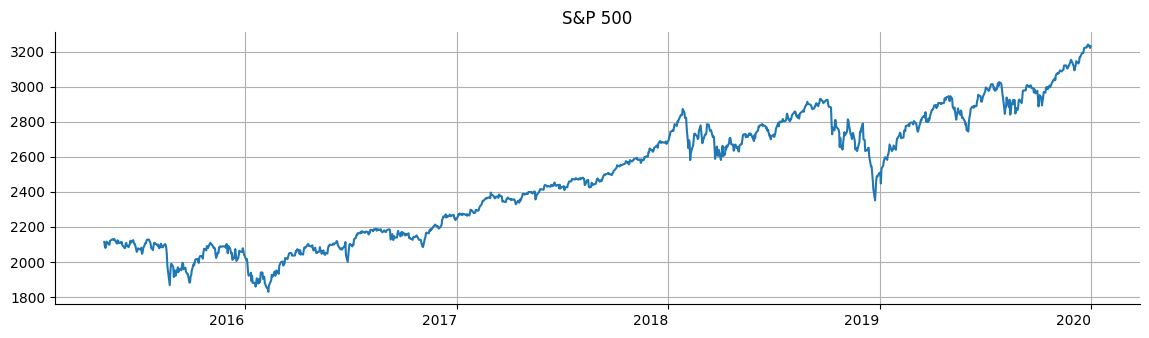

In [30]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()

ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()
plt.grid()
plt.show()

### Preprocessing

In [41]:
scaler = MinMaxScaler()

In [43]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)

sp500_scaled.describe()

count    1175.000000
mean        0.461000
std         0.251346
min         0.000000
25%         0.209197
50%         0.456696
75%         0.677640
max         1.000000
dtype: float64

#### Generating Recurrent Sequences from our Time Series

In [46]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) 
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [48]:
window_size = 63

In [50]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [52]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2015-08-03,0.202284,0.184544,0.177945,0.183509,0.203425,0.195791,0.191390,0.190937,0.206968,0.208124,...,0.212057,0.205629,0.202043,0.193538,0.177591,0.169079,0.187230,0.198088,0.198130,0.194735
2015-08-04,0.184544,0.177945,0.183509,0.203425,0.195791,0.191390,0.190937,0.206968,0.208124,0.212709,...,0.205629,0.202043,0.193538,0.177591,0.169079,0.187230,0.198088,0.198130,0.194735,0.190625
2015-08-05,0.177945,0.183509,0.203425,0.195791,0.191390,0.190937,0.206968,0.208124,0.212709,0.211738,...,0.202043,0.193538,0.177591,0.169079,0.187230,0.198088,0.198130,0.194735,0.190625,0.187279
2015-08-06,0.183509,0.203425,0.195791,0.191390,0.190937,0.206968,0.208124,0.212709,0.211738,0.210335,...,0.193538,0.177591,0.169079,0.187230,0.198088,0.198130,0.194735,0.190625,0.187279,0.191900
2015-08-07,0.203425,0.195791,0.191390,0.190937,0.206968,0.208124,0.212709,0.211738,0.210335,0.213857,...,0.177591,0.169079,0.187230,0.198088,0.198130,0.194735,0.190625,0.187279,0.191900,0.180362


In [54]:
y.head()

DATE
2015-08-03    0.190625
2015-08-04    0.187279
2015-08-05    0.191900
2015-08-06    0.180362
2015-08-07    0.176117
dtype: float64

In [56]:
X.shape

(1112, 63)

#### Train-Test Split

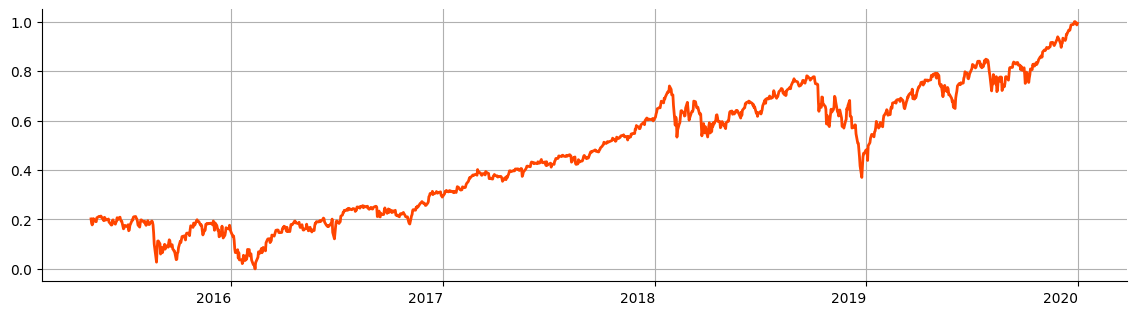

In [61]:
ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0, color='orangered')
ax.set_xlabel('')
sns.despine()
plt.grid()
plt.show()

In [74]:
X_train = X.loc[:'2018-12-31'].values.reshape(-1, window_size, 1)
y_train = y.loc[:'2018-12-31']

X_test = X.loc['2019'].values.reshape(-1, window_size, 1)
y_test = y.loc['2019']

In [76]:
n_obs, window_size, n_features = X_train.shape

In [78]:
y_train.shape

(860,)

### Keras LSTM Layer

#### Defining Model Architecture

In [94]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

2025-05-04 07:06:08.225809: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-04 07:06:08.225866: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-04 07:06:08.225877: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-04 07:06:08.225915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-04 07:06:08.225942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [96]:
rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

### Training Model

In [103]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [107]:
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

In [109]:
rnn_path = (results_path / 'rnn.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [113]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150


2025-05-04 07:09:19.040041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1123 
Epoch 1: val_loss improved from inf to 0.06498, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1090 - val_loss: 0.0650
Epoch 2/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 
Epoch 2: val_loss improved from 0.06498 to 0.01205, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0120
Epoch 3/150
35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011     
Epoch 3: val_loss improved from 0.01205 to 0.00366, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 4/150
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9773e-04 
Epoch 4: val_loss did not improve from 0.00366
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1127e-04 - val_loss: 0.0043
Epoch 5/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1159e-04 
Epoch 5: val_loss improved from 0.00366 to 0.00317, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1026e-04 - val_loss: 0.0032
Epoch 6/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8338e-04 
Epoch 6: val_loss improved from 0.00317 to 0.00231, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8965e-04 - val_loss: 0.0023
Epoch 7/150
35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9342e-04
Epoch 7: val_loss did not improve from 0.00231
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0706e-04 - val_loss: 0.0027
Epoch 8/150
34/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0214e-04 
Epoch 8: val_loss did not improve from 0.00231
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9307e-04 - val_loss: 0.0030
Epoch 9/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3177e-04 
Epoch 9: val_loss improved from 0.00231 to 0.00113, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3159e-04 - val_loss: 0.0011
Epoch 10/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0756e-04 
Epoch 10: val_loss did not improve from 0.00113
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0772e-04 - val_loss: 0.0012
Epoch 11/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1266e-04 
Epoch 11: val_loss did not improve from 0.00113
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2203e-04 - val_loss: 0.0013
Epoch 12/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3380e-04 
Epoch 12: val_loss did not improve from 0.00113
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2577e-04 - val_loss: 0.0014
Epoch 13/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6678e-04 
Epoch 13: val_loss improved from 0.00113 to 0.00080, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6652e-04 - val_loss: 8.0339e-04
Epoch 14/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7039e-04 
Epoch 14: val_loss did not improve from 0.00080
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7808e-04 - val_loss: 0.0015
Epoch 15/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0143e-04
Epoch 15: val_loss did not improve from 0.00080
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8649e-04 - val_loss: 8.3116e-04
Epoch 16/150
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8213e-04 
Epoch 16: val_loss did not improve from 0.00080
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6636e-04 - val_loss: 0.0010
Epoch 17/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6918e-04
Epoch 17: val_loss improved from 0.00080 to 0.00055, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6933e-04 - val_loss: 5.4752e-04
Epoch 18/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9362e-04 
Epoch 18: val_loss did not improve from 0.00055
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9161e-04 - val_loss: 8.1484e-04
Epoch 19/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2672e-04 
Epoch 19: val_loss did not improve from 0.00055
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1799e-04 - val_loss: 0.0015
Epoch 20/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4896e-04 
Epoch 20: val_loss did not improve from 0.00055
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4896e-04 - val_loss: 7.0389e-04
Epoch 21/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7677e-04 
Epoch 21: val_loss did not improve from 0.00055
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8467e-04 - val_loss: 9.7504e-04
Epoch 22/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0330e-04 
Epoch 22: val_loss did not improve from 0.00055

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6198e-04 - val_loss: 4.6812e-04
Epoch 25/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4030e-04 
Epoch 25: val_loss did not improve from 0.00047
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4076e-04 - val_loss: 4.7254e-04
Epoch 26/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9964e-04 
Epoch 26: val_loss did not improve from 0.00047
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9965e-04 - val_loss: 9.6188e-04
Epoch 27/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8782e-04 
Epoch 27: val_loss did not improve from 0.00047
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8799e-04 - val_loss: 6.6833e-04
Epoch 28/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5185e-04 
Epoch 28: val_loss did not improve from 0.00047
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5834e-04 - val_loss: 0.0011
Epoch 29/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9355e-04 
Epoch 29: val_loss improved from 0.00047 to 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9382e-04 - val_loss: 3.9392e-04
Epoch 30/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7711e-04 
Epoch 30: val_loss did not improve from 0.00039
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7964e-04 - val_loss: 6.3066e-04
Epoch 31/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7720e-04 
Epoch 31: val_loss did not improve from 0.00039
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7722e-04 - val_loss: 6.3789e-04
Epoch 32/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0056e-04 
Epoch 32: val_loss improved from 0.00039 to 0.00038, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9766e-04 - val_loss: 3.8280e-04
Epoch 33/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3351e-04 
Epoch 33: val_loss improved from 0.00038 to 0.00036, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3694e-04 - val_loss: 3.6118e-04
Epoch 34/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2857e-04 
Epoch 34: val_loss did not improve from 0.00036
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3402e-04 - val_loss: 4.6212e-04
Epoch 35/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4284e-04 
Epoch 35: val_loss did not improve from 0.00036
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4477e-04 - val_loss: 3.6731e-04
Epoch 36/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4972e-04 
Epoch 36: val_loss did not improve from 0.00036
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5158e-04 - val_loss: 3.8406e-04
Epoch 37/150
35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6743e-04 
Epoch 37: val_loss improved from 0.00036 to 0.00036, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8272e-04 - val_loss: 3.5792e-04
Epoch 38/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0946e-04 
Epoch 38: val_loss improved from 0.00036 to 0.00035, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1897e-04 - val_loss: 3.4909e-04
Epoch 39/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8670e-04 
Epoch 39: val_loss improved from 0.00035 to 0.00034, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9693e-04 - val_loss: 3.3615e-04
Epoch 40/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8736e-04 
Epoch 40: val_loss did not improve from 0.00034
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8231e-04 - val_loss: 3.5004e-04
Epoch 41/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3150e-04 
Epoch 41: val_loss did not improve from 0.00034
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3181e-04 - val_loss: 5.7284e-04
Epoch 42/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4989e-04 
Epoch 42: val_loss improved from 0.00034 to 0.00033, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4798e-04 - val_loss: 3.3179e-04
Epoch 43/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9119e-04 
Epoch 43: val_loss did not improve from 0.00033
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8662e-04 - val_loss: 5.1177e-04
Epoch 44/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6500e-04 
Epoch 44: val_loss did not improve from 0.00033
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6372e-04 - val_loss: 3.6620e-04
Epoch 45/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4464e-04 
Epoch 45: val_loss did not improve from 0.00033
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4358e-04 - val_loss: 3.6842e-04
Epoch 46/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1859e-04
Epoch 46: val_loss did not improve from 0.00033
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2021e-04 - val_loss: 4.4265e-04
Epoch 47/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8401e-04 
Epoch 47: val_loss did not improve from 0.00

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4341e-04 - val_loss: 3.0777e-04
Epoch 54/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7322e-04 
Epoch 54: val_loss did not improve from 0.00031
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7901e-04 - val_loss: 4.4643e-04
Epoch 55/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0124e-04 
Epoch 55: val_loss did not improve from 0.00031
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0038e-04 - val_loss: 3.7496e-04
Epoch 56/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1010e-04 
Epoch 56: val_loss improved from 0.00031 to 0.00031, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0832e-04 - val_loss: 3.0671e-04
Epoch 57/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3711e-04 
Epoch 57: val_loss did not improve from 0.00031
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3995e-04 - val_loss: 5.9831e-04
Epoch 58/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2071e-04 
Epoch 58: val_loss did not improve from 0.00031
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1718e-04 - val_loss: 4.8554e-04
Epoch 59/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9106e-04 
Epoch 59: val_loss did not improve from 0.00031
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9348e-04 - val_loss: 3.1486e-04
Epoch 60/150
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3666e-04 
Epoch 60: val_loss did not improve from 0.00031
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4209e-04 - val_loss: 6.1844e-04
Epoch 61/150
35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7961e-04 
Epoch 61: val_loss did not improve from 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8933e-04 - val_loss: 3.0061e-04
Epoch 76/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3058e-04 
Epoch 76: val_loss improved from 0.00030 to 0.00028, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3629e-04 - val_loss: 2.8369e-04
Epoch 77/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1910e-04 
Epoch 77: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1356e-04 - val_loss: 3.9276e-04
Epoch 78/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4882e-04 
Epoch 78: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5199e-04 - val_loss: 4.3852e-04
Epoch 79/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3064e-04 
Epoch 79: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3626e-04 - val_loss: 3.4792e-04
Epoch 80/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8222e-04 
Epoch 80: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8056e-04 - val_loss: 3.4102e-04
Epoch 81/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7650e-04 
Epoch 81: val_loss did not improve from 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4437e-04 - val_loss: 2.8087e-04
Epoch 83/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9186e-04 
Epoch 83: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8762e-04 - val_loss: 3.7734e-04
Epoch 84/150
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5413e-04 
Epoch 84: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5485e-04 - val_loss: 2.8650e-04
Epoch 85/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2725e-04 
Epoch 85: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2295e-04 - val_loss: 3.0140e-04
Epoch 86/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8653e-04 
Epoch 86: val_loss did not improve from 0.00028
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8585e-04 - val_loss: 3.1939e-04
Epoch 87/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9072e-04 
Epoch 87: val_loss did not improve from 0.0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7756e-04 - val_loss: 2.7175e-04
Epoch 96/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6136e-04 
Epoch 96: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6193e-04 - val_loss: 2.7460e-04
Epoch 97/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3437e-04 
Epoch 97: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3822e-04 - val_loss: 3.3515e-04
Epoch 98/150
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1662e-04 
Epoch 98: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2426e-04 - val_loss: 6.9053e-04
Epoch 99/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0654e-04 
Epoch 99: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0049e-04 - val_loss: 2.9631e-04
Epoch 100/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8623e-04 
Epoch 100: val_loss did not improve from 0

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3507e-04 - val_loss: 2.7084e-04
Epoch 115/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2233e-04 
Epoch 115: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2686e-04 - val_loss: 2.8031e-04
Epoch 116/150
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4423e-04 
Epoch 116: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4461e-04 - val_loss: 3.4803e-04
Epoch 117/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2662e-04 
Epoch 117: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2723e-04 - val_loss: 7.4653e-04
Epoch 118/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1310e-04 
Epoch 118: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1845e-04 - val_loss: 2.7674e-04
Epoch 119/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0380e-04 
Epoch 119: val_loss did not improv

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7451e-04 - val_loss: 2.6720e-04
Epoch 126/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1717e-04 
Epoch 126: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2246e-04 - val_loss: 2.7126e-04
Epoch 127/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3246e-04 
Epoch 127: val_loss improved from 0.00027 to 0.00026, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3468e-04 - val_loss: 2.6456e-04
Epoch 128/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3340e-04 
Epoch 128: val_loss did not improve from 0.00026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3419e-04 - val_loss: 4.0607e-04
Epoch 129/150
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3597e-04 
Epoch 129: val_loss did not improve from 0.00026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3760e-04 - val_loss: 3.9679e-04
Epoch 130/150
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2645e-04 
Epoch 130: val_loss improved from 0.00026 to 0.00026, saving model to results/univariate_time_series/rnn.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2941e-04 - val_loss: 2.6397e-04
Epoch 131/150
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2375e-04 
Epoch 131: val_loss did not improve from 0.00026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2625e-04 - val_loss: 2.8802e-04
Epoch 132/150
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3213e-04 
Epoch 132: val_loss did not improve from 0.00026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3324e-04 - val_loss: 2.6969e-04
Epoch 133/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7025e-04 
Epoch 133: val_loss did not improve from 0.00026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6961e-04 - val_loss: 2.6829e-04
Epoch 134/150
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7237e-04 
Epoch 134: val_loss did not improve from 0.00026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6895e-04 - val_loss: 3.5936e-04
Epoch 135/150
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5550e-04 
Epoch 135: val_loss did not improv

### Evaluating Model Performance

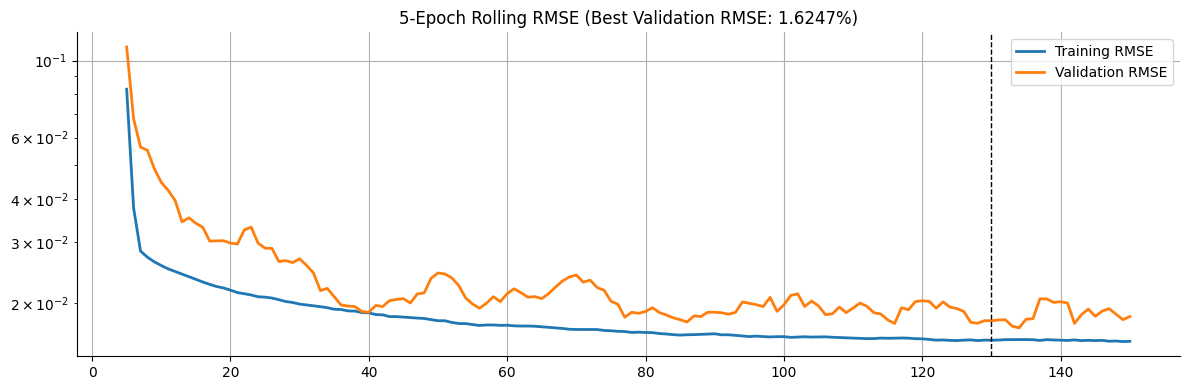

In [122]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);
plt.grid()
plt.show()

In [124]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))

test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))

print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0157 | Test RMSE: 0.0162


In [126]:
train_predict_scaled = rnn.predict(X_train)

test_predict_scaled = rnn.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [128]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]

test_ic = spearmanr(y_test, test_predict_scaled)[0]

print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9961 | Test IC: 0.9807


#### Rescaling Predictions

In [131]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)

test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [133]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()

y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [135]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))

test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))

f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 22.15 | Test RMSE: 22.92'

In [139]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict

sp500 = sp500.join(
    pd.concat([
        train_predict.to_frame('predictions').assign(data='Train'),
        test_predict.to_frame('predictions').assign(data='Test')
    ])
)

#### Plotting Results

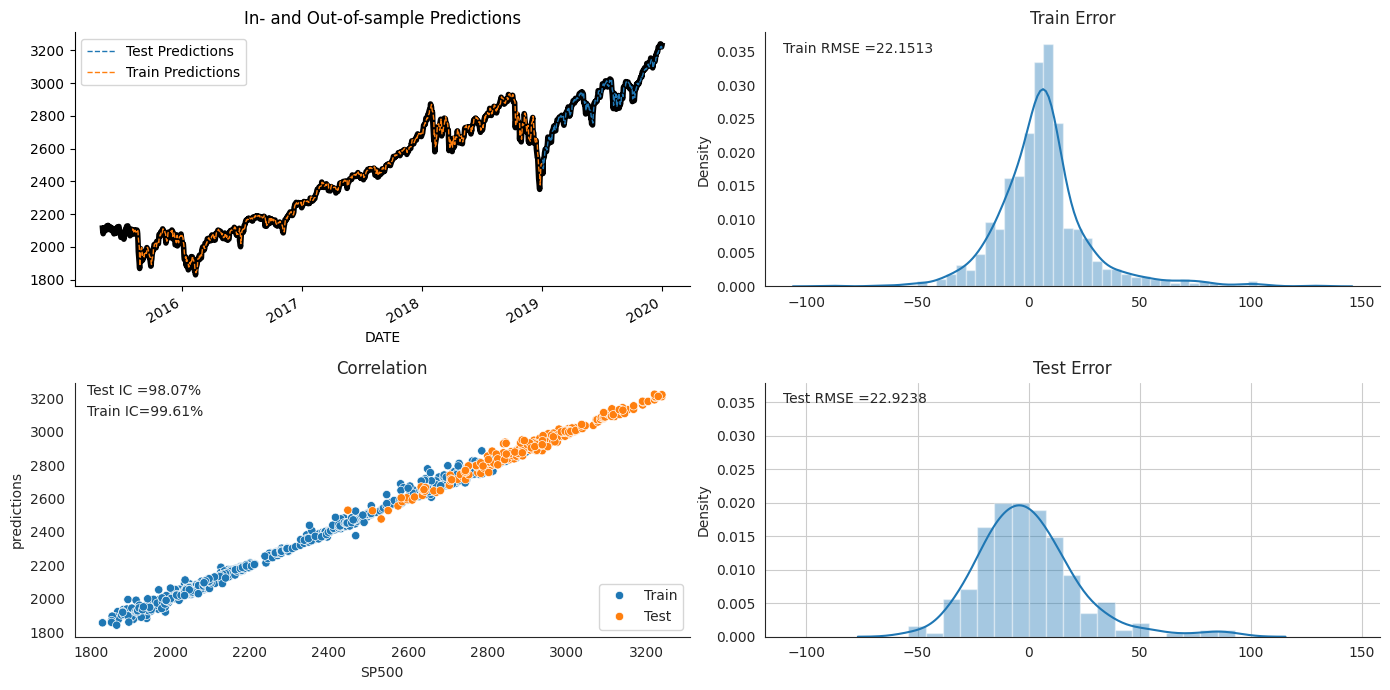

In [142]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);
plt.grid()
plt.show()